# Regression for Car price Prediction

AutoScout24 provided us with a dump of their productive database. You are assigned to train a prediction model for the selling price of second-hand cars, which in the future shall enable the platform to automatically suggest an adequate selling price whenever a customer uploads a new sale advertisement.

<a href="https://www.autoscout24.ch/de"><img src="https://www.autoscout24.ch/MVC/Content/desktop/img/autoscout24-logo-og.png" height="30%" width="30%"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import KFold

from tqdm.notebook import tqdm
import ipywidgets as widgets
%matplotlib inline

### Load the data

In [2]:
df = pd.read_csv("cars.csv", parse_dates=['Registration'])

In [3]:
df.shape

(55208, 12)

In [4]:
df.head(n=5)

,Name,Price,Mileage,Registration,Color,Doors,Horsepower,EngineSize,Seats,Cylinders,Gears,Year
0,MERCEDES-BENZ SL 500,44800,27600,1996-10-01,anthrazit,2,320,4973,2,8,5,1996
1,BMW 740iL,22800,18300,1999-05-01,anthrazit,4,286,4398,5,8,5,1999
2,AUDI A8 4.2 FSI quattro,183710,650,2008-08-01,anthrazit,5,350,4172,5,8,6,2008
3,OPEL Zafira 2.2i Cosmo,19900,32000,2006-02-01,anthrazit,5,150,2198,7,4,6,2006
4,VOLVO V70 D5 AWD A,18999,118000,2003-02-01,anthrazit,5,163,2401,5,5,5,2003


### Data Preparation

Here we set datatypes and indices, split fields, maybe join tables if we have multiple input sources and so on. In this exercise, the data is mostly clean and well-prepared. All we have to do is set the datatypes. Please note that you can do this directly with pd.read_csv if you want (as shown above with the `parse_date` argument).

##### Handle categorical variables

One variable is categorical. Encode it as Pandas datatype `categorical` (you can use [pd.DataFrame.astype()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.astype.html)) and print the dtypes afterwards.

In [5]:
df["Color"] = df["Color"].astype("category")
df.dtypes

Name                    object
Price                    int64
Mileage                  int64
Registration    datetime64[ns]
Color                 category
Doors                    int64
Horsepower               int64
EngineSize               int64
Seats                    int64
Cylinders                int64
Gears                    int64
Year                     int64
dtype: object

In [6]:
df.Color = df.Color.astype('category')
df.dtypes

Name                    object
Price                    int64
Mileage                  int64
Registration    datetime64[ns]
Color                 category
Doors                    int64
Horsepower               int64
EngineSize               int64
Seats                    int64
Cylinders                int64
Gears                    int64
Year                     int64
dtype: object

### Data Analysis and Quality Assessment

To get to know the data and to get a feeling for it, it is important to examine it before doing any modelling. Data Cleaning and Data Analysis (also called Explorative Data Analysis) are a large part of Machine Learning.

##### Duplicates

Let's begin by checking for duplicate rows. With the data at hand, exact duplicates should not occur. While it is of course possible that two cars of the same maker and model are being sold, the mileage and registration probably would not match. Exact duplicates thus hint at an anomaly from entering, processing or extracting the data (which is in fact very common).

> Find out if there are rows that are exact duplicates. If there are, examine and possibly drop them. You can use [pd.DataFrame.duplicated()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.duplicated.html) and [pd.DataFrame.drop_duplicates()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop_duplicates.html).

In [7]:
# check if they are any
print('dataset contains duplicates: %s' % df.duplicated().any())
df.drop_duplicates(inplace=True)
print('dataset contains duplicates: %s' % df.duplicated().any())


dataset contains duplicates: True
dataset contains duplicates: False


In [8]:
# check if they are any
df.duplicated().any()

False

In [9]:
# if there are, print them...

In [10]:
# since there are, print them
df[df.duplicated(keep=False)].head(n=10)

,Name,Price,Mileage,Registration,Color,Doors,Horsepower,EngineSize,Seats,Cylinders,Gears,Year


In [11]:
# ... and drop them

In [12]:
# and drop them
df.drop_duplicates(inplace=True)
#df = df.drop_duplicates() # same result

##### Null values

> Now check for null values.

In [13]:
df.isna().any()

Name            False
Price           False
Mileage         False
Registration    False
Color           False
Doors           False
Horsepower      False
EngineSize      False
Seats           False
Cylinders       False
Gears           False
Year            False
dtype: bool

In [14]:
df.isna().any() # add another .any() to aggregate to a single Boolean

Name            False
Price           False
Mileage         False
Registration    False
Color           False
Doors           False
Horsepower      False
EngineSize      False
Seats           False
Cylinders       False
Gears           False
Year            False
dtype: bool

##### Data ranges

> Check if the date ranges make sense.

In [15]:
df.Year.min(), df.Year.max()

(1900, 2014)

In [16]:
df.Registration.min(), df.Registration.max()

(Timestamp('1900-01-01 00:00:00'), Timestamp('2014-01-01 00:00:00'))

Even though that could be (the [oldest car](https://en.wikipedia.org/wiki/History_of_the_automobile) is quite a bit older than 1900), it is unlikely that cars from 1900 will be sold on AutoScout24. We need to examine ...

But first, it is also a bit suspicious that both the Registration and the Year show the same range. Maybe we have redundant information that we can drop?

##### Redundant data

> Check whether the year from *Registration* and the *Year* column are identical. You can use the [.dt accessor](https://pandas.pydata.org/pandas-docs/stable/basics.html#basics-dt-accessors) to get the year from the registration date.

In [17]:
(df.Registration.dt.year == df.Year).all()

True

In [18]:
(df.Registration.dt.year == df.Year).all()

True

> Next, check if there is variation in the day of the Registration date. You can use [.nunique()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.nunique.html) or [.value_counts()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html) for this.

In [19]:
(df.Registration.dt.year == df.Year).value_counts()

True    54738
dtype: int64

In [20]:
df.Registration.dt.day.value_counts()

1    54738
Name: Registration, dtype: int64

So the *Registration* column contains the same year that we also have in the *Year* column and an additional month. The day is always 1.

To simplify the rest of this exercise, let's only keep the *Year* column. For more detailed analysis, you might want to keep the month, however.

> Drop the *Registration* column.

In [21]:
df.drop('Registration', axis=1, inplace=True)

In [22]:
#df.drop('Registration', axis='columns', inplace=True)

KeyError: "['Registration'] not found in axis"

##### Data ranges again

Now back to these very old cars. 

> Sort the dataframe so that the oldest cars show first and list the first 5 entries.

In [23]:
df.sort_values(by='Year', ascending=True).head(5)

,Name,Price,Mileage,Color,Doors,Horsepower,EngineSize,Seats,Cylinders,Gears,Year
47125,HYUNDAI i30 1.6 GDI STYLE,29130,10,silber,5,135,1591,5,4,6,1900
22513,MERCEDES-BENZ SL-CLASS 280 Pagode,47800,65000,rot,2,170,2778,4,6,4,1968
22791,SUZUKI Samurai Wagon EFI,6700,60000,rot,3,69,1298,4,4,5,1985
4108,SUZUKI Samurai Wagon EFI,6900,51000,blau,3,69,1298,4,4,5,1985
23209,SUZUKI Samurai Wagon 30 Kmh,6900,45000,rot,3,69,1298,4,4,5,1986


In [24]:
df.sort_values(by='Year').head()

,Name,Price,Mileage,Color,Doors,Horsepower,EngineSize,Seats,Cylinders,Gears,Year
47125,HYUNDAI i30 1.6 GDI STYLE,29130,10,silber,5,135,1591,5,4,6,1900
22513,MERCEDES-BENZ SL-CLASS 280 Pagode,47800,65000,rot,2,170,2778,4,6,4,1968
22791,SUZUKI Samurai Wagon EFI,6700,60000,rot,3,69,1298,4,4,5,1985
4108,SUZUKI Samurai Wagon EFI,6900,51000,blau,3,69,1298,4,4,5,1985
23209,SUZUKI Samurai Wagon 30 Kmh,6900,45000,rot,3,69,1298,4,4,5,1986


Googling these, it looks like only the first row has an invalid Year and the remaining are ok. 

>Select the row with year 1900 and drop it.

In [25]:
df.drop(df.index[47125], axis='rows', inplace=True)

In [26]:
df.drop(df.index[df.Year==1900], axis='rows', inplace=True)

Now we calculate basic statistics and check if they are reasonable.

In [27]:
df.describe()

,Price,Mileage,Doors,Horsepower,EngineSize,Seats,Cylinders,Gears,Year
count,54736.000000,5.473600e+04,54736.000000,54736.00000,54736.000000,54736.000000,54736.000000,54736.000000,54736.000000
mean,29810.248063,5.292026e+04,4.340178,171.39590,2114.637332,4.806489,4.559686,5.797647,2008.689966
std,30787.749867,5.993445e+04,1.047182,93.17266,961.463807,0.911267,1.365183,0.857753,4.407130
min,300.000000,0.000000e+00,2.000000,40.00000,599.000000,2.000000,2.000000,1.000000,1968.000000
25%,12400.000000,1.500000e+03,4.000000,112.00000,1560.000000,5.000000,4.000000,5.000000,2006.000000
50%,21900.000000,2.986250e+04,5.000000,150.00000,1968.000000,5.000000,4.000000,6.000000,2010.000000
75%,36950.000000,8.975000e+04,5.000000,200.00000,2290.000000,5.000000,4.000000,6.000000,2012.000000
max,698000.000000,1.530000e+06,6.000000,777.00000,8285.000000,14.000000,12.000000,8.000000,2014.000000


Do you see anything else suspicious? 
> Feel free to examine further.

##### Outliers

Let's next take care of outliers. As we have seen in the lecture, outliers can affect the performance of algorithms that are based on distance or similarity.

We create a boxplot for the four numerical columns.

Price            AxesSubplot(0.125,0.536818;0.352273x0.343182)
Mileage       AxesSubplot(0.547727,0.536818;0.352273x0.343182)
Horsepower          AxesSubplot(0.125,0.125;0.352273x0.343182)
EngineSize       AxesSubplot(0.547727,0.125;0.352273x0.343182)
dtype: object

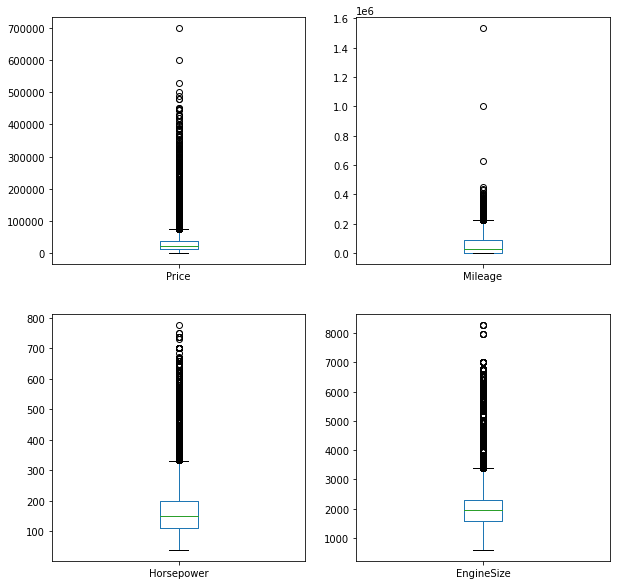

In [28]:
numerical_cols = ['Price', 'Mileage', 'Horsepower', 'EngineSize']
df.loc[:, numerical_cols].plot(kind='box', subplots=True, layout=(2, 2), figsize=(10, 10), sharex=False)

According to the rule that values at least 1.5 * IQR above the 3rd quartile or below the 1st quartile are considered outliers, we have many of those (the circles in the boxplot). However, as we already have checked the validity of the data ranges, we assume that these do not signify a problem with the data (such as wrongly entered data), but are in fact valid, but extreme samples.

For algorithms that are heavily influenced by outliers (such as Linear Regression), it might be best to remove them anyway. But this is something that has to be evaluated with experiments and cross-validation. Furthermore, it is very important that statistics such as the mean for normalisation and the IQR for outlier removal are computed on the training set only (meaning *after* a cross-validation split and not *before*). 

We will skip outlier removal for now and look at it again in detail in one of the next exercises. The following code is just given for reference. 

In [29]:
# The following code can be used to calculate an upper bound.
# If applied, this bound must be calculated only on the training set, not on the complete dataset.
# In a dataset where there are outliers above as well as below the two quartiles, the lower bound
# would have to be calculated accordingly
if False:
    q3 = df.loc[:, numerical_cols].describe().loc['75%']
    iqr = q3 - df.loc[:, numerical_cols].describe().loc['25%']
    upper_boundary = q3 + 1.5*iqr
    upper_boundary

In [30]:
# And here the outliers are removed
if False:
    df = df[(df.Price <= upper_boundary.Price) &
            (df.Mileage <= upper_boundary.Mileage) &
            (df.Horsepower <= upper_boundary.Horsepower) &
            (df.EngineSize <= upper_boundary.EngineSize)]

##### Data distribution and pairwise relation

Lastly, let's look at the distributions and the pairwise relations. 

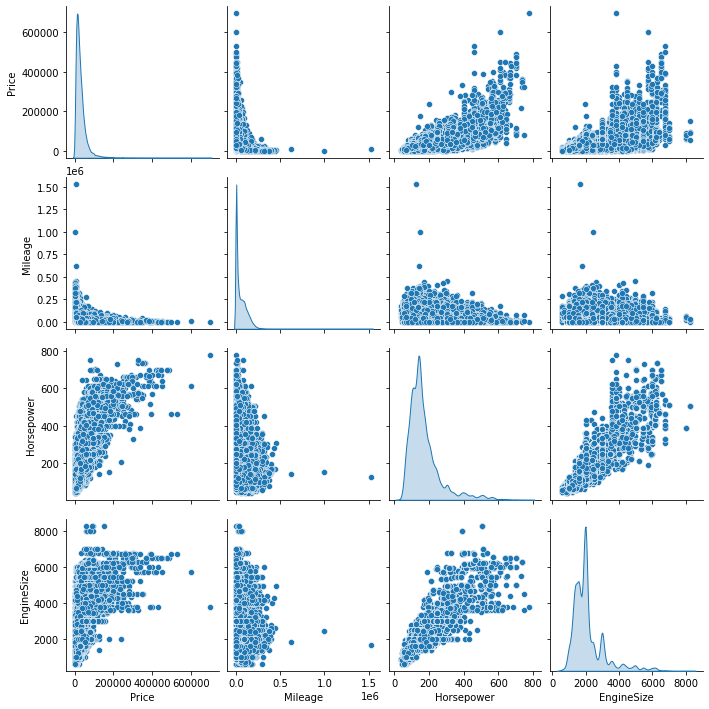

In [31]:
sns.pairplot(df.loc[:, numerical_cols], diag_kind = "kde", kind = "scatter")

# or with just pandas:
# pd.plotting.scatter_matrix(df.loc[:, numerical_cols], diagonal='kde')

We see that all distributions are right-skewed. It might be beneficial to transform them, another experiment that would have to be evaluated with cross-validation. We also see the expected linear relationship between Horsepower and EngineSize. Something else to expect which is not supported by the data at hand could be a linear relationship between Mileage and Price.

And certain outliers are also visible. Let's remove them now.

Remove the 3 elements with the largest Mileage.

In [32]:
df.sort_values(by='Mileage', ascending=False).head(n=6)

,Name,Price,Mileage,Color,Doors,Horsepower,EngineSize,Seats,Cylinders,Gears,Year
17010,HONDA FR-V 1.7 Comfort,7990,1530000,grau,5,125,1668,7,4,5,2006
7734,SUBARU Legacy 2.5 Outback A,1000,999999,blau,5,150,2457,5,4,4,1997
47002,TOYOTA Celica 1.8 VVT-i,7900,623750,silber,3,143,1794,4,4,6,2000
4668,MERCEDES-BENZ S 500 L,6800,450000,blau,4,306,4966,4,8,5,1999
7808,MERCEDES-BENZ E 240 Avantgarde,1900,437899,blau,5,170,2597,5,6,6,2001
26322,MERCEDES-BENZ E 430 Avantgarde,3800,431000,schwarz,4,279,4266,5,8,5,1998


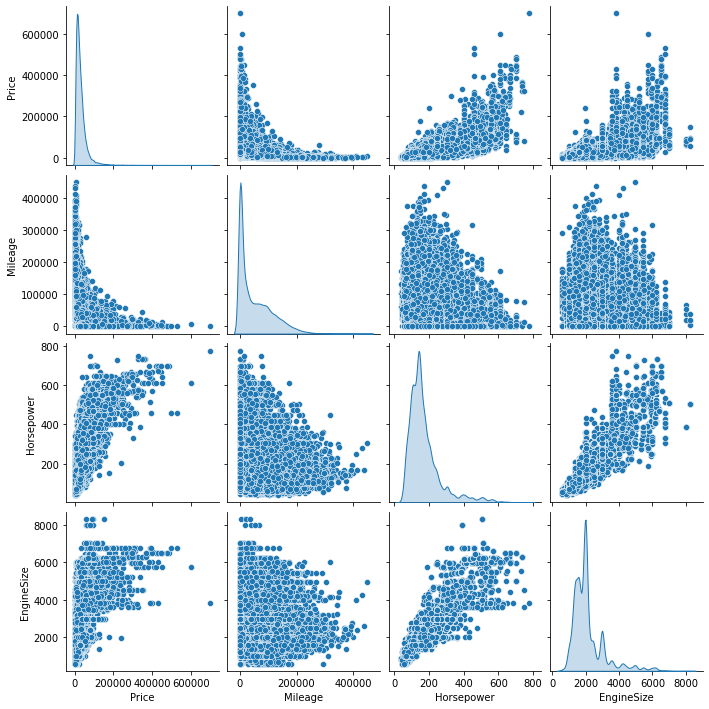

In [33]:
df.drop([17010, 7734, 47002], axis='rows', inplace=True)
sns.pairplot(df.loc[:, numerical_cols], diag_kind = "kde", kind = "scatter")

Remove the 2 samples with the largest Price.

In [34]:
df.sort_values(by='Price', ascending=False).head(n=6)

,Name,Price,Mileage,Color,Doors,Horsepower,EngineSize,Seats,Cylinders,Gears,Year
44369,RUF CTR 3 Clubsport,698000,150,silber,2,777,3800,2,6,7,2013
24720,PORSCHE Carrera GT,600000,6000,schwarz,2,612,5733,2,10,6,2006
29735,ROLLS-ROYCE Phantom 6.7 V12 Drophead Series II,529999,1,schwarz,2,460,6749,4,12,8,2013
43004,ROLLS-ROYCE Phantom 6.7 V12 Series II,499999,1,silber,4,460,6749,5,12,8,2013
31720,LAMBORGHINI Aventador LP700-4 Coup?® MY13,489000,160,schwarz,2,700,6498,2,12,7,2013
21854,LAMBORGHINI Aventador LP700-4 Cp?®,478500,2500,grün,2,700,6498,2,12,7,2013


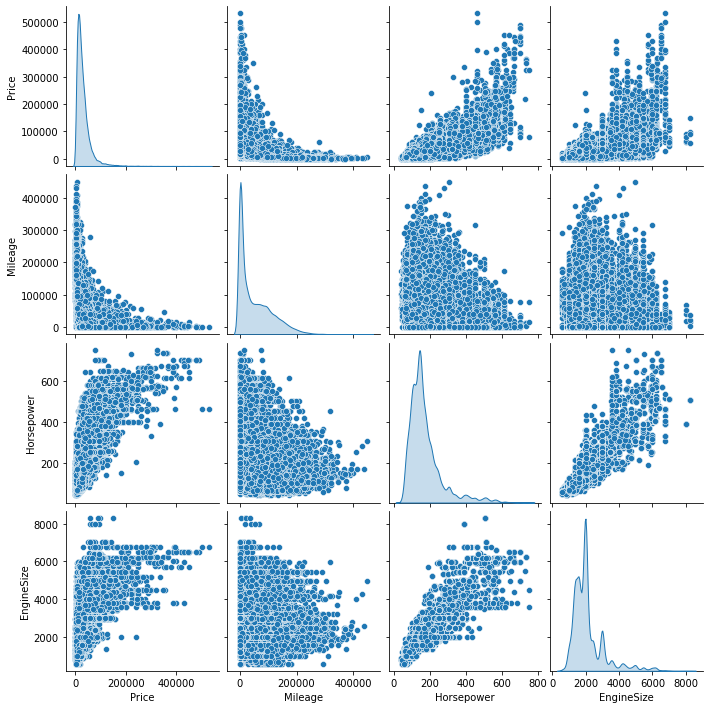

In [35]:
df.drop([44369, 24720], axis='rows', inplace=True)
sns.pairplot(df.loc[:, numerical_cols], diag_kind = "kde", kind = "scatter")

Remove the 8 samples with the largest EngineSize.

In [36]:
df.sort_values(by='EngineSize', ascending=False).head(n=12)

,Name,Price,Mileage,Color,Doors,Horsepower,EngineSize,Seats,Cylinders,Gears,Year
23294,DODGE Viper SRT-10,149900,3500,rot,2,506,8285,2,10,6,2008
23306,DODGE Viper SRT-10,57000,21000,rot,2,506,8285,2,10,6,2006
29763,DODGE Viper SRT-10,89000,37000,schwarz,2,506,8285,2,10,6,2006
22503,DODGE VIPER SRT-10,97000,17000,rot,2,506,8277,2,10,6,2004
11359,CHRYSLER Viper GTS,59800,66900,grau,2,389,7990,2,10,6,2000
24039,CHRYSLER Viper GTS,92000,39000,rot,2,389,7990,2,10,6,1999
26905,CHRYSLER Viper GTS,79000,53000,schwarz,2,389,7990,2,10,6,2000
23281,CHRYSLER Viper GTS,64900,19800,rot,2,389,7990,2,10,6,2000
3596,CHEVROLET Corvette Z06,110015,100,blau,2,512,7011,2,8,6,2012
8225,CHEVROLET Corvette Z06,57500,14500,blau,2,512,7011,2,8,6,2006


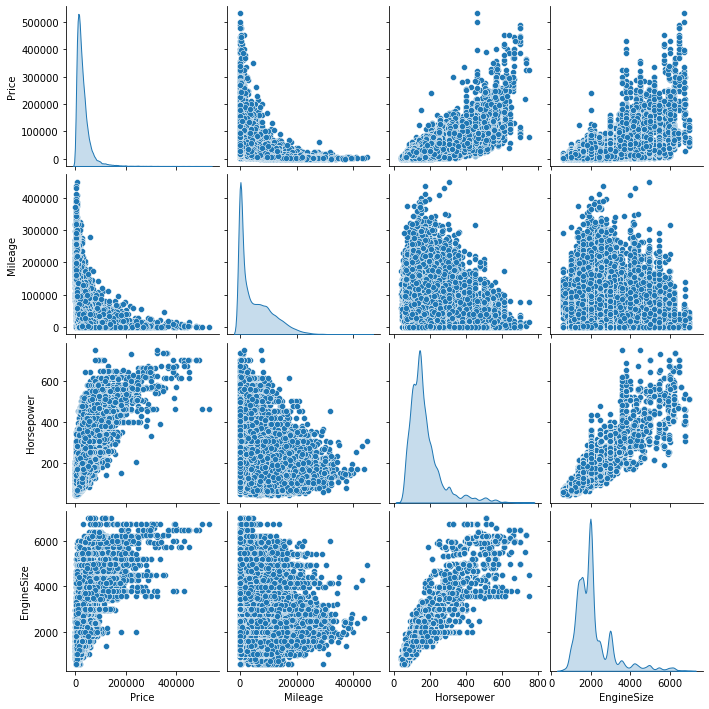

In [37]:
df.drop(df.index[df.EngineSize > 7500], axis='rows', inplace=True)
sns.pairplot(df.loc[:, numerical_cols], diag_kind = "kde", kind = "scatter")

Okay, let's leave it at that.

## Price prediction

Ok, now that we have done our data quality assessment, let's dive into the [Scikit-learn](https://scikit-learn.org/) toolkit. Our goal is to fit a model which is able to predict the price of a car. We are going to use the **K-Nearest Neighbor (KNN)** algorithm for this regression problem.

### Feature Engineering
Before we can train our model, we have to do some feature engineering. Let's take a look at our dataset again.

In [38]:
df.head()

,Name,Price,Mileage,Color,Doors,Horsepower,EngineSize,Seats,Cylinders,Gears,Year
0,MERCEDES-BENZ SL 500,44800,27600,anthrazit,2,320,4973,2,8,5,1996
1,BMW 740iL,22800,18300,anthrazit,4,286,4398,5,8,5,1999
2,AUDI A8 4.2 FSI quattro,183710,650,anthrazit,5,350,4172,5,8,6,2008
3,OPEL Zafira 2.2i Cosmo,19900,32000,anthrazit,5,150,2198,7,4,6,2006
4,VOLVO V70 D5 AWD A,18999,118000,anthrazit,5,163,2401,5,5,5,2003


Since we now actually use the categorical column, we need to transform it. Use [pd.get_dummies()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) and [pd.concat](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.concat.html) to [One-Hot encode](https://en.wikipedia.org/wiki/One-hot) the *Color* column (in the lecture, this is described in the section *Vector Space Model*).

Then, drop the original *Colors* column.

In [39]:
df = pd.concat([df, pd.get_dummies(df.Color)], axis='columns')
df.drop('Color', axis='columns', inplace=True)
df.head()

,Name,Price,Mileage,Doors,Horsepower,EngineSize,Seats,Cylinders,Gears,Year,...,grau,grün,orange,pink,rot,schwarz,silber,türkis,violett,weiss
0,MERCEDES-BENZ SL 500,44800,27600,2,320,4973,2,8,5,1996,...,0,0,0,0,0,0,0,0,0,0
1,BMW 740iL,22800,18300,4,286,4398,5,8,5,1999,...,0,0,0,0,0,0,0,0,0,0
2,AUDI A8 4.2 FSI quattro,183710,650,5,350,4172,5,8,6,2008,...,0,0,0,0,0,0,0,0,0,0
3,OPEL Zafira 2.2i Cosmo,19900,32000,5,150,2198,7,4,6,2006,...,0,0,0,0,0,0,0,0,0,0
4,VOLVO V70 D5 AWD A,18999,118000,5,163,2401,5,5,5,2003,...,0,0,0,0,0,0,0,0,0,0


In [40]:
#df = pd.concat([df, pd.get_dummies(df.Color)], axis='columns')
#df.drop('Color', axis='columns', inplace=True)
#df.head()

AttributeError: 'DataFrame' object has no attribute 'Color'

And we still have that name column, which isn't really useful. One possibility would be to treat it as a categorical variable. Let's check how many different car names that would yield.

In [41]:
pd.get_dummies(df.Name).count()

ALFA ROMEO 145 1.4 TS 16V L             54723
ALFA ROMEO 145 1.8 TS 16V L             54723
ALFA ROMEO 145 1.9 JTD                  54723
ALFA ROMEO 145 2.0 TS 16V Quadrifog.    54723
ALFA ROMEO 146 2.0 Ti 16V               54723
                                        ...  
VW up 1.0 BMT move up                   54723
VW up! 1.0 BMT move up                  54723
WIESMANN GT MF4                         54723
WIESMANN GT MF5 20th anniversary        54723
WIESMANN Roadster MF3                   54723
Length: 14683, dtype: int64

In [42]:
df.Name.nunique()

14683

Too many. If we want to use this information, we need to either make bins or dissect the column into subfields. This is a bit of work, so to keep it simple, extract the brand from the beginning of the string and use this as a feature. This is a simplification, and it doesn't get everything right, e.g. brand names with a space such as 'LAND ROVER' or 'ASTON MARTIN' are truncated. But for the sake of the exercise, let's be happy with that.

Use the [.str accessor](https://pandas.pydata.org/pandas-docs/stable/text.html#splitting-and-replacing-strings) to split the Name column, [map](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) with a lambda expression to take only the brand and assign to a new column called *Brand*. Then drop the Name column.

In [43]:
#for name in df.Name:
#    df["Brand"] = (name.split(" "))[0]
#df.head()
    

In [44]:
df['Brand'] = df.Name.str.split(' ').map(lambda x: x[0])
df.drop('Name', axis='columns', inplace=True)
df.head()

,Price,Mileage,Doors,Horsepower,EngineSize,Seats,Cylinders,Gears,Year,anthrazit,...,grün,orange,pink,rot,schwarz,silber,türkis,violett,weiss,Brand
0,44800,27600,2,320,4973,2,8,5,1996,1,...,0,0,0,0,0,0,0,0,0,MERCEDES-BENZ
1,22800,18300,4,286,4398,5,8,5,1999,1,...,0,0,0,0,0,0,0,0,0,BMW
2,183710,650,5,350,4172,5,8,6,2008,1,...,0,0,0,0,0,0,0,0,0,AUDI
3,19900,32000,5,150,2198,7,4,6,2006,1,...,0,0,0,0,0,0,0,0,0,OPEL
4,18999,118000,5,163,2401,5,5,5,2003,1,...,0,0,0,0,0,0,0,0,0,VOLVO


In [45]:
df.Brand.nunique()

70

In [46]:
df

,Price,Mileage,Doors,Horsepower,EngineSize,Seats,Cylinders,Gears,Year,anthrazit,...,grün,orange,pink,rot,schwarz,silber,türkis,violett,weiss,Brand
0,44800,27600,2,320,4973,2,8,5,1996,1,...,0,0,0,0,0,0,0,0,0,MERCEDES-BENZ
1,22800,18300,4,286,4398,5,8,5,1999,1,...,0,0,0,0,0,0,0,0,0,BMW
2,183710,650,5,350,4172,5,8,6,2008,1,...,0,0,0,0,0,0,0,0,0,AUDI
3,19900,32000,5,150,2198,7,4,6,2006,1,...,0,0,0,0,0,0,0,0,0,OPEL
4,18999,118000,5,163,2401,5,5,5,2003,1,...,0,0,0,0,0,0,0,0,0,VOLVO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55203,29900,40000,5,167,2457,5,4,6,2011,0,...,0,0,0,0,0,0,0,0,1,SUBARU
55204,4800,59000,3,68,998,4,3,5,2011,0,...,0,0,0,0,0,0,0,0,1,PEUGEOT
55205,51800,2000,2,184,1796,2,4,7,2013,0,...,0,0,0,0,0,0,0,0,1,MERCEDES-BENZ
55206,36500,29000,2,320,3696,4,6,7,2011,0,...,0,0,0,0,0,0,0,0,1,INFINITI


Now we have a new categorical variable. Again we have to [One-Hot encode](https://en.wikipedia.org/wiki/One-hot) this column.

In [47]:
df = pd.concat([df, pd.get_dummies(df.Brand)], axis='columns')
df.drop('Brand', axis='columns', inplace=True)
df.head()

,Price,Mileage,Doors,Horsepower,EngineSize,Seats,Cylinders,Gears,Year,anthrazit,...,SMART,SSANG,SUBARU,SUZUKI,TATA,TOYOTA,TVR,VOLVO,VW,WIESMANN
0,44800,27600,2,320,4973,2,8,5,1996,1,...,0,0,0,0,0,0,0,0,0,0
1,22800,18300,4,286,4398,5,8,5,1999,1,...,0,0,0,0,0,0,0,0,0,0
2,183710,650,5,350,4172,5,8,6,2008,1,...,0,0,0,0,0,0,0,0,0,0
3,19900,32000,5,150,2198,7,4,6,2006,1,...,0,0,0,0,0,0,0,0,0,0
4,18999,118000,5,163,2401,5,5,5,2003,1,...,0,0,0,0,0,0,0,1,0,0


In [48]:
#df = pd.concat([df, pd.get_dummies(df.Brand)], axis='columns')
#df.drop('Brand', axis='columns', inplace=True)

AttributeError: 'DataFrame' object has no attribute 'Brand'

Now our Dataframe looks like this:

In [ ]:
df.head()

We probably have too many features in relation to the amount of data. So let's start by only using 5 features.
As a next step, we split the features from the target *(price)* we are going to predict.

In [49]:
feature_columns = ['Mileage', 'Year', 'Horsepower', 'Doors', 'schwarz']

In [50]:
X = df[feature_columns].values
# We convert it to float so we don't get a conversion warning when normalizing the data
X = X.astype("float") 
y = df.Price.values

#### Splitting the data
Split the data into a training and test set using the [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function. Use 20% of the data for the test set. Then print  the shapes of the resulting data sets and make sure the splitting was correct.

In [51]:
# X_train, ...
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train", y_train.shape)
print("y_test", y_test.shape)

X_train: (43778, 5)
X_test: (10945, 5)
y_train (43778,)
y_test (10945,)


In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train:", X_train.shape)
print("y_train", y_train.shape)
print("X_test:", X_test.shape)
print("y_test", y_test.shape)

X_train: (43778, 5)
y_train (43778,)
X_test: (10945, 5)
y_test (10945,)


In [53]:
print(X_train[0])

[2.100e+03 2.013e+03 7.360e+02 3.000e+00 1.000e+00]


### Baseline Model

To get an idea how good our model performs, it often makes sense to implement a baseline model. In our case the baseline model should just returns the median of the price. For that case we can use the [DummyRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html) from sklearn.

Instantiate a new DummyRegressor with the strategy `median`

In [54]:
dummy = DummyRegressor(strategy="median")
dummy.fit(X_train, y_train)

DummyRegressor(strategy='median')

In [55]:
dummy = DummyRegressor(strategy="median")

Now fit the model on the training data.

In [56]:
# dummy.fit(...)

In [57]:
dummy.fit(X_train, y_train)

DummyRegressor(strategy='median')

Congrats, you have trained your first model (even though the model is pretty dumb :-))! Let's check how good the baseline model performs.

But first we need to make a prediction on the test set.

In [58]:
y_pred = dummy.predict(X_test)
y_pred

array([21900., 21900., 21900., ..., 21900., 21900., 21900.])

In [59]:
y_pred = dummy.predict(X_test)

We will measure the quality of our result with the [Mean Absolute Error (MAE)](https://en.wikipedia.org/wiki/Mean_absolute_error). This means that we don't care whether we estimate a price as too high or too low, only the magnitude of the difference counts. We will also calculate the [Coefficient of Determination (R<sup>2</sup>) score](https://en.wikipedia.org/wiki/Coefficient_of_determination). Our goal is to minimize the MAE and to maximize the R<sup>2</sup> score.

Calculate the [Mean Absolute Error (MAE)](https://en.wikipedia.org/wiki/Mean_absolute_error) for the predictions made on the test set. Implement it yourself instead of using the Scikit-Learn toolkit.

In [60]:
# Calculate the MAE
def mae(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))
mae(y_test, y_pred)

18036.50196436729

In [61]:
np.mean(np.abs(y_test - y_pred))

18036.50196436729

Scikit-Learn also provides the function [mean_absolute_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html) so we don't have to implement it ourseleves.

In [62]:
mean_absolute_error(y_test, y_pred)

18036.50196436729

The R<sup>2</sup> score can be calculated using the Scikit-Learn function [r2_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html).

In [63]:
r2_score(y_test, y_pred)

-0.06550794505669932

### K-Nearest Neighbors (KNN)

Okay, our baseline model is pretty bad! Let's see if we can improve our performance with a KNN-model.

#### Normalize the data
When using the K-Nearest Neighbors algorithm it is important to normalize the data. We use the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) from Scikit-Learn which represents the Z-Score normalization.

In [64]:
print("Original", X_train[0])

Original [2.100e+03 2.013e+03 7.360e+02 3.000e+00 1.000e+00]


In [65]:
scaler = StandardScaler()

Now that we have instantiated the scaler, we could call the `fit` method, which will calculate the *variance* and *mean* per feature store it. We then call `transform` to apply the normalization to the data. 

In [66]:
# fit the scaler and then transform
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [67]:
scaler.fit(X_train)
X_train = scaler.transform(X_train)

# You could also call fit_transform, which calls fit first and then transforms the data.
# X_train_scaled = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [68]:
print("Mean per feature:", scaler.mean_)
print("Variance per feature", scaler.var_)

Mean per feature: [-1.90265618e-16  1.97868838e-14  1.82431823e-16  1.22117939e-15
 -1.21492554e-15]
Variance per feature [1. 1. 1. 1. 1.]


In [69]:
print("Scaled", X_train[0])

Scaled [-0.85535136  0.97962757  6.06340142 -1.2814797   1.66493678]


As we have measured the performance of the baseline model, we can start to use an actual machine learning model. We will use the [KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) model.
Instantiate a new object of the `KNeighborsRegressor` model. Set the hyperparameter `n_neighbors` equal to 5. Then fit the model on the training data and calculate the metrics on the test set.

In [70]:
# Instantiate model
knr = KNeighborsRegressor(n_neighbors=5)

In [71]:
knr = KNeighborsRegressor(n_neighbors=5)

In [72]:
# Fit the model

In [73]:
knr.fit(X_train, y_train)

KNeighborsRegressor()

In [74]:
# Predict on the test set
# y_test = ...

In [75]:
y_pred = knr.predict(X_test)
y_pred_train = knr.predict(X_train)

In [76]:
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("MAE:", mae)
print("r2:", r2)

MAE: 6252.0115669255365
r2: 0.8431772920084168


In [77]:
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("MAE:", mae)
print("r2:", r2)

MAE: 6252.0115669255365
r2: 0.8431772920084168


## Hyperparameter Tuning

The KNeighborsRegressor has the hyperparameter `n_neighbors` that we would like to tune. As explained in the lecture you **should not use the test set** to tune the hyperparameters. Therefore we further split the training set into a validation set or use a k-fold cross-validation. 



#### Splitting the data
Split the original data into the following: 60% training data, 20% validation, 20% test data. Make sure the splitting is correct by checking the shapes.

In [78]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)
 X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, shuffle=False)
 print("X_train:", X_train.shape)
 print("y_train", y_train.shape)
 print("X_val", X_val.shape)
 print("y_val", y_val.shape)
 print("X_test:", X_test.shape)
 print("y_test", y_test.shape)

X_train: (32833, 5)
y_train (32833,)
X_val (10945, 5)
y_val (10945,)
X_test: (10945, 5)
y_test (10945,)


In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
print("X_train:", X_train.shape)
print("y_train", y_train.shape)
print("X_val", X_val.shape)
print("y_val", y_val.shape)
print("X_test:", X_test.shape)
print("y_test", y_test.shape)

X_train: (32833, 5)
y_train (32833,)
X_val (10945, 5)
y_val (10945,)
X_test: (10945, 5)
y_test (10945,)


#### Normalization
Again, apply z-normalization to the data

In [80]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [81]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

#### Manually select best parameter
Let's select the value for `n_neighbors` where we get the highest R<sup>2</sup> score.

In [82]:
@widgets.interact(k=widgets.IntSlider(
    value=1,
    min=1,
    max=12,
    step=1,
    description='n_neighbors:'))
def f(k):
    knr = KNeighborsRegressor(n_neighbors=k)
    knr.fit(X_train, y_train)
    y_pred = knr.predict(X_val)
    r2 = r2_score(y_val, y_pred)
    print("K={} -> r2={}".format(k, r2))

interactive(children=(IntSlider(value=1, description='n_neighbors:', max=12, min=1), Output()), _dom_classes=(…

#### Automatically select best parameter
Now let's try different values for `n_neighbors` by looping through a list of possible values. We want to automatically select the parameter for `n_neighbors` which results in the highest R<sup>2</sup> score.

In [83]:
r2_scores = []
r2bestAsIndex = 0
k_range = list(range(1, 13))
for k in tqdm(k_range):
    # START YOUR CODE
    knr = KNeighborsRegressor(n_neighbors=k)
    knr.fit(X_train, y_train)
    y_pred = knr.predict(X_val)
    r2 = r2_score(y_val, y_pred)
    r2_scores.append(r2)
    if r2 > r2_scores[r2bestAsIndex]:
        r2bestAsIndex = k-1
    
    # END YOUR CODE
    #print("K={} -> r2={}".format(k, r2))
    pass
print("K={} -> r2={}".format(r2bestAsIndex+1, r2_scores[r2bestAsIndex]))

#idx = np.argmax(r2_scores)
#best_k = k_range[idx]
#max_r2 = np.max(r2_scores)
#print("Best K:", best_k)
#print("max r:", max_r2)


K=4 -> r2=0.8416911672279223


In [84]:
r2_scores = []
k_range = list(range(1, 13))
for k in tqdm(k_range):
    knr = KNeighborsRegressor(n_neighbors=k)
    knr.fit(X_train, y_train)
    y_pred = knr.predict(X_val)
    r2 = r2_score(y_val, y_pred)
    r2_scores.append(r2)
    print("K={} -> r2={}".format(k, r2))
    
idx = np.argmax(r2_scores)
best_k = k_range[idx]
max_r2 = np.max(r2_scores)
print("Best K:", best_k)
print("max r2:", max_r2)

K=1 -> r2=0.7777390042939624
K=2 -> r2=0.8288766219775743
K=3 -> r2=0.8341657887469072
K=4 -> r2=0.8416911672279223
K=5 -> r2=0.8357796574836076
K=6 -> r2=0.8385462470548248
K=7 -> r2=0.8347663517482428
K=8 -> r2=0.8358297669081977
K=9 -> r2=0.8350232184804577
K=10 -> r2=0.8352274098102679
K=11 -> r2=0.8338406530938278
K=12 -> r2=0.8325229550241021

Best K: 4
max r2: 0.8416911672279223


We can now plot how the R<sup>2</sup> score changes when we increase K.

Text(0, 0.5, 'r2')

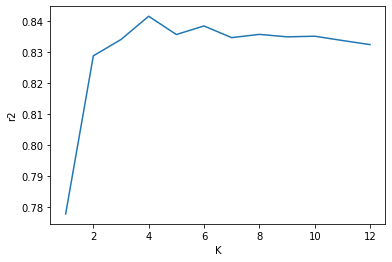

In [85]:
plt.plot(k_range, r2_scores)
plt.xlabel("K")
plt.ylabel("r2")

Now that we have found the our optimal number of neighbors, we can now finally evaluate how good our model performs on the test set. 

**Note**: Until now we should have never touched the test set. If we want to further improve our model after looking at the test data we would need to split the data again! Otherwise our result might be optimistically biased.

In [86]:
knr = KNeighborsRegressor(n_neighbors=best_k)
knr.fit(X_train, y_train)

y_pred = knr.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("r2: ", r2)

r2:  0.7964192634337699


### Cross-Validation

What we have done so far is a so called 1-fold cross-validation: We splitted our data into a training, test and validation set. Now we want to perform a k-fold cross validation.

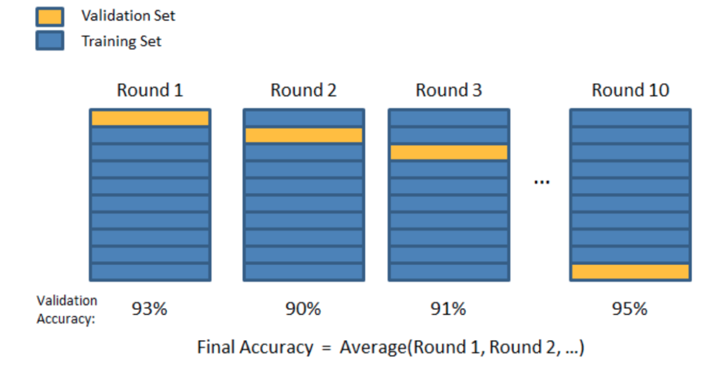

##### Splitting the data
When we do cross-validation we split our data set into a training and a test set and then split the training set during the cross-validation into a training and validation set.

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train:", X_train.shape)
print("y_train", y_train.shape)
print("X_test:", X_test.shape)
print("y_test", y_test.shape)

X_train: (43778, 5)
y_train (43778,)
X_test: (10945, 5)
y_test (10945,)


For applying cross-validation use the [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class from Sci-Kit learn to further split the training data into a training and validation set. Use the `split` method and don't forget to normalize your data.

In [88]:
def apply_cv(X, y, model, n_splits):
    y_trues = []
    y_preds = []
    # START YOUR CODE

    
    # END YOUR CODE
    return y_trues, y_preds

In [89]:
def apply_cv(X, y, model, n_splits):
    y_trues = []
    y_preds = []
    kf = KFold(n_splits=n_splits, random_state=42, shuffle=True)
    for train_index, val_index in kf.split(X):
        X_train_cv, X_val_cv = X[train_index], X[val_index] 
        y_train_cv, y_val_cv = y[train_index], y[val_index]

        X_train_cv = scaler.fit_transform(X_train_cv)
        X_val_cv = scaler.transform(X_val_cv)

        model.fit(X_train_cv, y_train_cv)
        y_pred = model.predict(X_val_cv)
        
        y_trues.extend(y_val_cv.tolist())
        y_preds.extend(y_pred.tolist())
    return y_trues, y_preds

We can now use our implemented method `apply_cv` to run the 10-fold cross-validation for our dataset.

In [90]:
y_trues, y_preds = apply_cv(X_train, y_train, model=knr, n_splits=10)
MAE = mean_absolute_error(y_trues, y_preds)
r2 = r2_score(y_trues, y_preds)
print("MAE:", MAE)
print("r2:", r2)

MAE: 6358.628335008451
r2: 0.8257609887633515


We have now implemented a simple cross-validation function. Let's use this function now for tuning the `n_neighbors` hyperparameter.

In [91]:
r2_scores = []
k_range = list(range(1, 13))
for k in tqdm(k_range):
    # START YOUR CODE

    
    # END YOUR CODE
    #print("K={} -> r2={}".format(k, r2))
    pass
    
#idx = np.argmax(r2_scores)
#best_k = k_range[idx]
#max_r2 = np.max(r2_scores)
#print("Best K:", best_k)
#print("max r2:", max_r2)

In [92]:
r2_scores = []
k_range = list(range(1, 13))
for k in tqdm(k_range):
    knr = KNeighborsRegressor(n_neighbors=k)
    y_trues, y_preds = apply_cv(X_train, y_train, knr, n_splits=10)
    y_pred = knr.predict(X_val)
    r2 = r2_score(y_trues, y_preds)
    r2_scores.append(r2)
    print("K={} -> r2={}".format(k, r2))
    
idx = np.argmax(r2_scores)
best_k = k_range[idx]
max_r2 = np.max(r2_scores)
print("Best K:", best_k)
print("max r2:", max_r2)

K=1 -> r2=0.7587583768217808
K=2 -> r2=0.8065485716794267
K=3 -> r2=0.823220127625546
K=4 -> r2=0.8257609887633515
K=5 -> r2=0.8260308334959211
K=6 -> r2=0.8264563537988396
K=7 -> r2=0.827130249984309
K=8 -> r2=0.8266630963157432
K=9 -> r2=0.8256010475591352
K=10 -> r2=0.826041460583085
K=11 -> r2=0.8257734205516987
K=12 -> r2=0.8260781069680412

Best K: 7
max r2: 0.827130249984309


### This is how it's done with Scikit-Learn

Scikit-Learn proides the function [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) which enables us tune the hyperparameters by applying a k-fold cross-validation. We have to create a `params` dictionary where we define all hyperparameters that we want to tune. We then pass the model, the parameters and specify the metric we want to optimize.

In [93]:
knr = KNeighborsRegressor()
params = {
    'n_neighbors': list(range(1, 13))
}
grid_search = GridSearchCV(knr, params, cv=10, scoring="r2")
grid_search.fit(X_train, y_train)
print("Best params", grid_search.best_params_)
print("max r2", grid_search.best_score_)

Best params {'n_neighbors': 5}
max r2 0.7619019102690677


The maximum R<sup>2</sup> score seems to be much lower than when we applied cross-validation ourselves. 

> Can you think of an explanation for this?

We did not apply normalization on the training data.

As you have seen, you should calculate the *variance* and *mean* for the z-score normalization from the training data. When we want to do a cross-validation, this makes it a bit complicated. Therefore Scikit-Learn has introduced [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). With a pipeline we can assemble multiple transformations and a final model into a combined model. When we then call the `fit` method, it will automatically preprocess the data before passing it to the model. In our case we use the pipline to combine the z-score normalization and the KNN model.

In [94]:
pipe =[("s", scaler), ("knr", knr)]
model = Pipeline(pipe)

When we call the `fit` and the `predict` methods, the passed data is automatically normalized before being used with the models. We don't have to care about scaling the data by ourselves.

In [95]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2_score(y_test, y_pred)
print(X_test)

[[1.390e+04 2.012e+03 1.400e+02 5.000e+00 0.000e+00]
 [1.100e+02 2.013e+03 1.400e+02 5.000e+00 1.000e+00]
 [1.000e+00 2.013e+03 1.000e+02 5.000e+00 0.000e+00]
 ...
 [4.300e+04 2.001e+03 4.000e+02 2.000e+00 1.000e+00]
 [1.000e+01 2.013e+03 9.500e+01 5.000e+00 1.000e+00]
 [5.000e+01 2.013e+03 1.400e+02 5.000e+00 0.000e+00]]


#### Cross-Validation using the pipeline
We can pass the pipeline instead of the `KNearestNeighborRegressor` object to the `GridSearchCV` class and run the grid search.

In [96]:
params = {
    'knr__n_neighbors': list(range(1, 13))
}
grid_search = GridSearchCV(model, params, cv=10, scoring="r2")
grid_search.fit(X_train, y_train)
print("Best params", grid_search.best_params_)
print("max r2", grid_search.best_score_)

Best params {'knr__n_neighbors': 5}
max r2 0.8302159285505022


As expected, the result is now much better.

## Assignment

Now answer the ILIAS Quiz **Supervised Learning Fundamentals**

> Fit a KNN-model with 6 neighbors and predict the price of a black car with the following properties:
* Mileage = 1000
* Year = 2012
* Horsepower = 150
* Doors = 5

In [108]:
df = pd.read_csv("cars.csv", parse_dates=['Registration'])
df["Color"] = df["Color"].astype("category")


# check if they are any
print('dataset contains duplicates: %s' % df.duplicated().any())
df.drop_duplicates(inplace=True)
print('dataset contains duplicates: %s' % df.duplicated().any())

df.drop('Registration', axis=1, inplace=True)

df.drop(df.index[47125], axis='rows', inplace=True)
df.drop(df.index[df.Year==1900], axis='rows', inplace=True)
df.drop([17010, 7734, 47002], axis='rows', inplace=True)
df.drop([44369, 24720], axis='rows', inplace=True)
df.drop(df.index[df.EngineSize > 7500], axis='rows', inplace=True)


df = pd.concat([df, pd.get_dummies(df.Color)], axis='columns')
df.drop('Color', axis='columns', inplace=True)

feature_columns = ['Mileage', 'Year', 'Horsepower', 'Doors', 'schwarz']

X = df[feature_columns].values
# We convert it to float so we don't get a conversion warning when normalizing the data
X = X.astype("float") 
y = df.Price.values

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

knr = KNeighborsRegressor(n_neighbors=6)
knr.fit(X, y)

# Car
dfCar = pd.read_csv("myCar.csv")

X_car = dfCar[feature_columns].values
X_car = X_car.astype("float")

X_car = scaler.transform(X_car)



y_pred = knr.predict(X_car)
print(y_pred)

dataset contains duplicates: True
dataset contains duplicates: False
[41445.]


In [103]:
# car with
dfCar = pd.read_csv("myCar.csv")
dfCar

feature_columns = ['Mileage', 'Year', 'Horsepower', 'Doors', 'schwarz']
X_car = dfCar[feature_columns].values
X = X_car.astype("float")

scaler = StandardScaler()
scaler.fit(X)

X_car = scaler.transform(X_car)


In [104]:
y_pred = knr.predict(X_car)
y_pred

array([24150.])

ValueError: Found input variables with inconsistent numbers of samples: [10945, 1]